In [1]:
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle
import constants

def create_grid_domains():
    ds = xr.open_dataset(f'{constants.nc_dir}1979-10.nc', chunks={'time': 100})
    start_lat, start_lon = 30, -125
    end_lat, end_lon = 55, -100
    grid_domains = {}
    total_domains = 0
    for lat in range(start_lat, end_lat, 4):
        for lon in range(start_lon, end_lon, 4):
            grid_domains[total_domains] = [lat, lat + 4, lon, lon + 4]
            total_domains += 1
    with open(f'{constants.domains_dir}grid_domains.pkl', 'wb') as f:
        pickle.dump(grid_domains, f)

create_grid_domains()

30 34 -125 -121
30.0 33.75 -125.0 -121.25
30 34 -121 -117
30.0 33.75 -121.0 -117.25
30 34 -117 -113
30.0 33.75 -117.0 -113.25
30 34 -113 -109
30.0 33.75 -113.0 -109.25
30 34 -109 -105
30.0 33.75 -109.0 -105.25
30 34 -105 -101
30.0 33.75 -105.0 -101.25
30 34 -101 -97
30.0 33.75 -101.0 -97.25
34 38 -125 -121
34.0 37.75 -125.0 -121.25
34 38 -121 -117
34.0 37.75 -121.0 -117.25
34 38 -117 -113
34.0 37.75 -117.0 -113.25
34 38 -113 -109
34.0 37.75 -113.0 -109.25
34 38 -109 -105
34.0 37.75 -109.0 -105.25
34 38 -105 -101
34.0 37.75 -105.0 -101.25
34 38 -101 -97
34.0 37.75 -101.0 -97.25
38 42 -125 -121
38.0 41.75 -125.0 -121.25
38 42 -121 -117
38.0 41.75 -121.0 -117.25
38 42 -117 -113
38.0 41.75 -117.0 -113.25
38 42 -113 -109
38.0 41.75 -113.0 -109.25
38 42 -109 -105
38.0 41.75 -109.0 -105.25
38 42 -105 -101
38.0 41.75 -105.0 -101.25
38 42 -101 -97
38.0 41.75 -101.0 -97.25
42 46 -125 -121
42.0 45.75 -125.0 -121.25
42 46 -121 -117
42.0 45.75 -121.0 -117.25
42 46 -117 -113
42.0 45.75 -117.0 -113.2

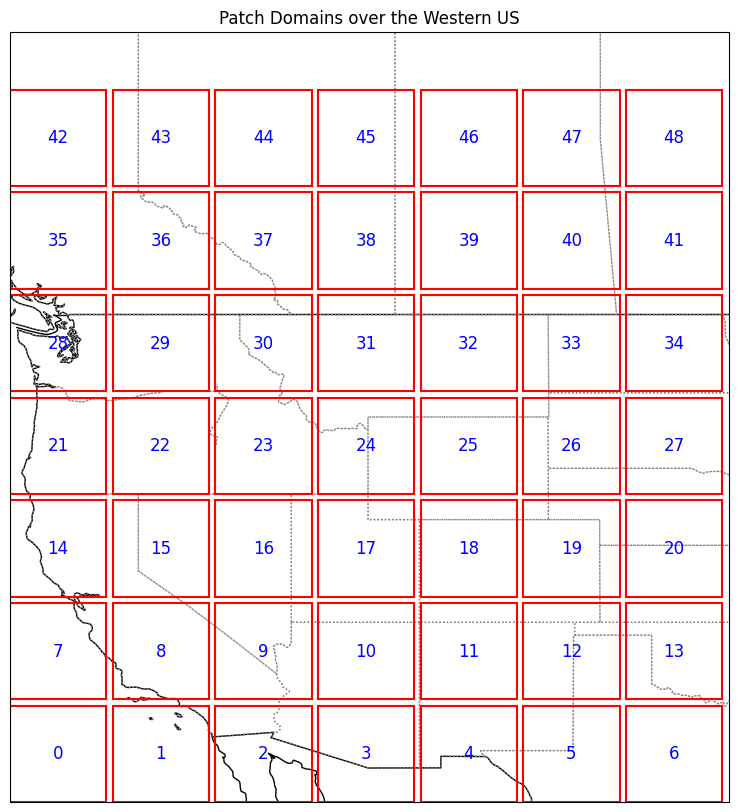

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

def plot_grid_domains(grid_file):
    # Load the grid domains
    with open(grid_file, 'rb') as f:
        grid_domains = pickle.load(f)

    # Create a figure and axis with the correct projection
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-125, -97, 30, 60], ccrs.PlateCarree())  # Western US region

    # Add features to the map
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # Plot each grid domain
    for domain_id, (lat_start, lat_end, lon_start, lon_end) in grid_domains.items():
        print(lat_start, lat_end, lon_start, lon_end)

        lat_values = np.arange(lat_start, lat_end, 0.25)
        lon_values = np.arange(lon_start, lon_end, 0.25)

        print(min(lat_values), max(lat_values), min(lon_values), max(lon_values))
        
        # Define the corner points of the grid box
        lon_min, lon_max = lon_values[0], lon_values[-1]
        lat_min, lat_max = lat_values[0], lat_values[-1]
        
        # Plot the rectangle for the grid domain
        ax.plot([lon_min, lon_max], [lat_min, lat_min], color='red')
        ax.plot([lon_min, lon_max], [lat_max, lat_max], color='red')
        ax.plot([lon_min, lon_min], [lat_min, lat_max], color='red')
        ax.plot([lon_max, lon_max], [lat_min, lat_max], color='red')
        
        # Place the domain ID in the center of the grid box
        ax.text((lon_min + lon_max) / 2, (lat_min + lat_max) / 2, str(domain_id), 
                color='blue', fontsize=12, ha='center', va='center')
    
    plt.title('Patch Domains over the Western US')
    plt.savefig('figures/patches.png')

# Usage
grid_file = '/Volumes/T9/domains/grid_domains.pkl'
plot_grid_domains(grid_file)